In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import pyepo
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from src.models.LinearRegression import LinearRegression

from src.solvers.spnia_asym import AsymmetricSPNI
from src.models.ShortestPathGrb import shortestPathGrb
from src.models.ShortestPathGrid import ShortestPathGrid
from src.solvers.BendersDecomposition import BendersDecomposition
from data.DataGenerator import DataGenerator
from src.models.trainer import Trainer

In [3]:
# Define hyperparameters
c_min: float = 1.0
c_max: float = 10.0
d_min: float = 1.0
d_max: float = 10.0
Q = 0.6
B = 5
network = (6, 8)
random_seed = 31

# ML hyperparameters
num_features = 5
num_data_samples = 1000
test_size = 0.2
data_loader_batch_size = 32
epochs = 5

# Set the random seed for reproducibility
np.random.seed(random_seed)

In [ ]:
# Define a graph with appropriate dimensions and an opt_model 
# for solving the shortest path problem on the graph
graph = ShortestPathGrid(network[0], network[1])
opt_model = shortestPathGrb(graph)

Restricted license - for non-production use only - expires 2026-11-23


In [5]:
# # Generate artificial data samples
# data_gen = DataGenerator(
#     num_costs=graph.num_cost,
#     num_features=num_features,
#     c_range=(c_min, c_max),
#     epsilon_bar=0.05
# )
# costs, features = data_gen.generate_data(num_samples=num_data_samples)

features, costs = pyepo.data.shortestpath.genData(
    1000, 
    num_features, 
    (graph.m, graph.n), 
    deg=3, 
    noise_width=0.05, 
    seed=31
)

# Split the data into training and testing sets
X_train, X_test, c_train, c_test = train_test_split(features, costs, test_size=test_size, random_state=random_seed)

# Create data loaders for training and testing
train_dataset = pyepo.data.dataset.optDataset(opt_model, X_train, c_train)
test_dataset = pyepo.data.dataset.optDataset(opt_model, X_test, c_test)

train_loader = DataLoader(train_dataset, batch_size=data_loader_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=data_loader_batch_size, shuffle=False)


Optimizing for optDataset...


100%|██████████| 800/800 [00:00<00:00, 1433.31it/s]

Optimizing for optDataset...



100%|██████████| 200/200 [00:00<00:00, 1607.33it/s]


In [6]:
# Instantiate linear regression model
model = LinearRegression(num_feat=num_features, num_edges=graph.num_cost)

# Init SPO+ loss
spop = pyepo.func.SPOPlus(opt_model, processes=1)

# Init optimizer
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-2)

Num of cores: 1


Epoch 00 | Train Loss: 6.5291 | Train Regret: 0.0646 | Test Loss: 2.6502 | Test Regret: 0.0770
Epoch 01 | Train Loss: 1.3545 | Train Regret: 0.0125 | Test Loss: 0.7502 | Test Regret: 0.0185
Epoch 02 | Train Loss: 0.4473 | Train Regret: 0.0072 | Test Loss: 0.3347 | Test Regret: 0.0079
Epoch 03 | Train Loss: 0.2677 | Train Regret: 0.0047 | Test Loss: 0.2704 | Test Regret: 0.0069
Epoch 04 | Train Loss: 0.2206 | Train Regret: 0.0047 | Test Loss: 0.2330 | Test Regret: 0.0053


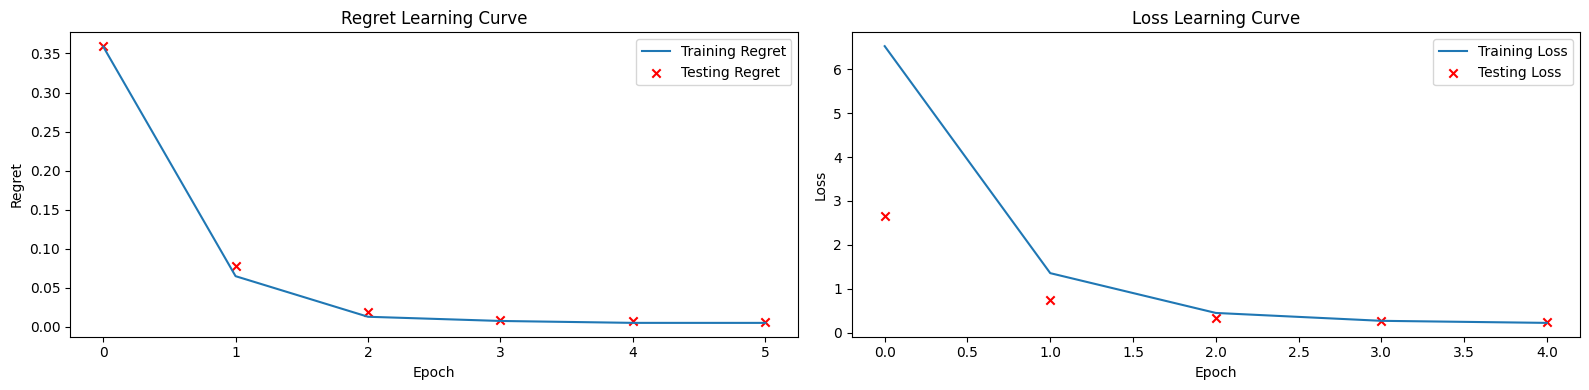

Final regret on test set:  0.005255037652905724


In [7]:
# Create a trainer instance
trainer = Trainer(pred_model=model, 
                  opt_model=opt_model, 
                  optimizer=optimizer, 
                  loss_fn=spop
                )

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(train_loader, test_loader, epochs=epochs)

# Plot the learning curve
Trainer.vis_learning_curve(
    trainer,
    train_loss_log,
    train_regret_log,
    test_loss_log,
    test_regret_log
)

print("Final regret on test set: ", test_regret_log[-1])